# TMVA Classification with Keras

This is an annotated version of the tutorial included in ROOT, available at `$ROOTSYS/tutorials/tmva/keras/ClassificationKeras.py`.

We start by importing the necessary Python modules. From the ROOT package, we import the TMVA (for the training and application of the classifiers), TFile (to perfom I/O with ROOT files), TTree (to process the trees within ROOT files), and TCut (to select events from the TTrees). We import som Python core packages we will need. Finally, we inlude the Keras components we will be using.

In [1]:
from ROOT import TMVA, TFile, TTree, TCut
from subprocess import call
from os.path import isfile

from keras import Sequential
from keras.layers import Dense, Activation
from keras.regularizers import l2
from keras.optimizers import SGD

Welcome to JupyROOT 6.24/06


2022-01-28 20:52:06.705620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.

We now proceed with the initialisation of TMVA, the opening of our input file, and the creation of a TMVA Factory, which will be used to control the training process.

In [2]:
# Setup TMVA
TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

# Setting output file and creating Factory
output = TFile.Open('TMVA-Classification-Keras.root', 'RECREATE')
factory = TMVA.Factory('TMVAClassification', output,
                       '!V:!Silent:Color:DrawProgressBar:Transformations=D,G:AnalysisType=Classification')

In order to process data, we need to load it. This is done using a DataLoader object. We look for the file in the local folder, and if not present, we download it from the ROOT website.

In [3]:
# Checking if the intput file is available locally, otherwise we download it
if not isfile('tmva_class_example.root'):
    call(['curl', '-O', 'http://root.cern/files/tmva_class_example.root'])

# Opening the file and getting the signal and background trees
data = TFile.Open('tmva_class_example.root')
signal = data.Get('TreeS')
background = data.Get('TreeB')

# Creating the DataLoader and adding each branch (variable) to the loader
dataloader = TMVA.DataLoader('dataset')
for branch in signal.GetListOfBranches():
    dataloader.AddVariable(branch.GetName())

# Assigning weights of 1.0 to the signal and background tree
dataloader.AddSignalTree(signal, 1.0)
dataloader.AddBackgroundTree(background, 1.0)

# Creating a training sample consisting of 4000 randome events
dataloader.PrepareTrainingAndTestTree(TCut(''),
             'nTrain_Signal=4000:nTrain_Background=4000:SplitMode=Random:NormMode=NumEvents:!V')



DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree TreeS of type Signal with 6000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree TreeB of type Background with 6000 events
                         : Dataset[dataset] : Class index : 0  name : Signal
                         : Dataset[dataset] : Class index : 1  name : Background


It is always important to take a look at the input variables. (This is not in the original tutorial.) In the plots below, the signal is in red and the background in blue.

Info in <TCanvas::Print>: pdf file ./TMVA Classification Keras Input Variables.pdf has been created


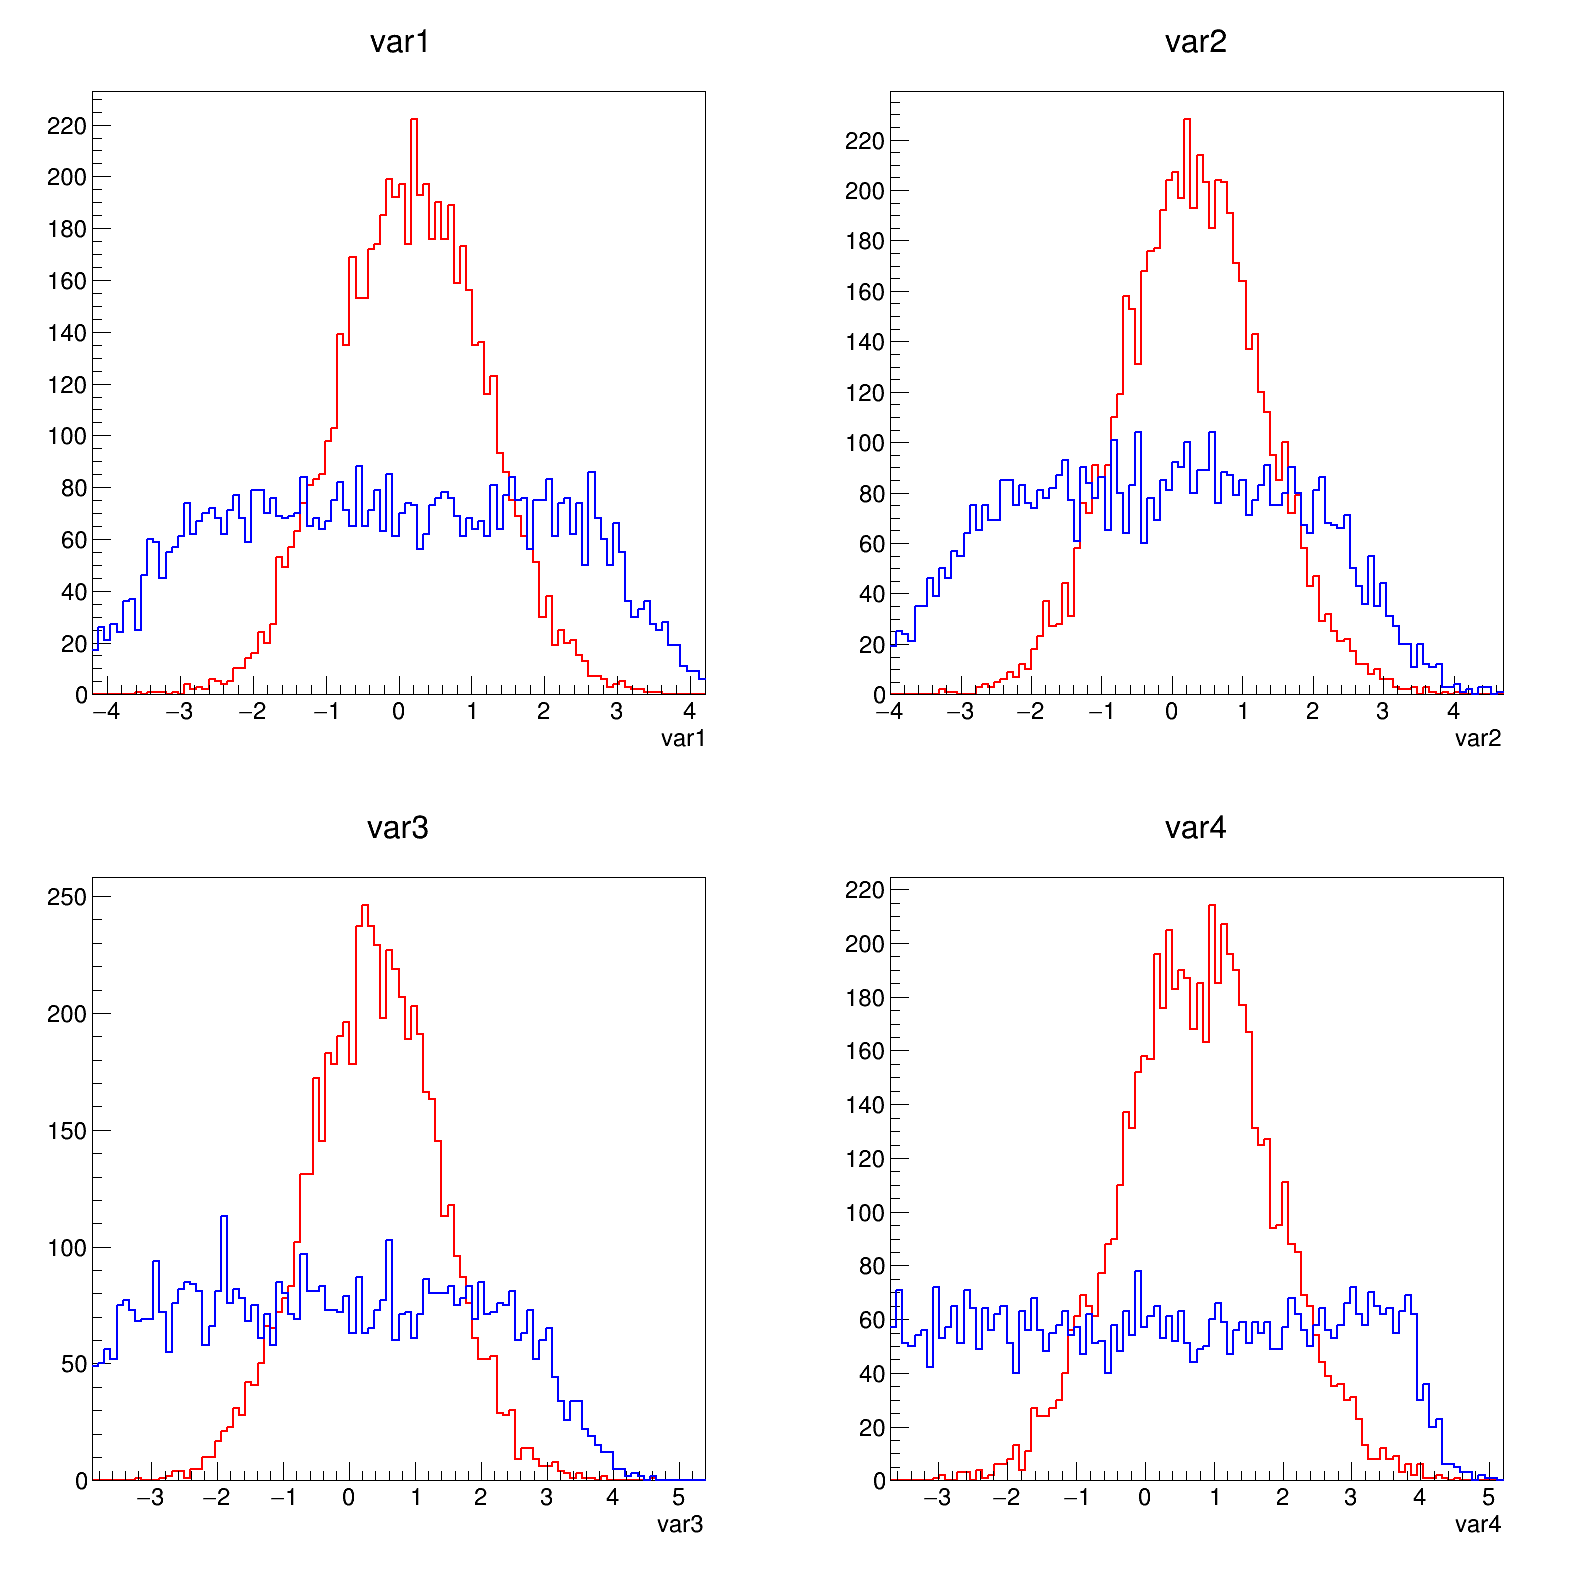

In [4]:
import ROOT
# Check the ROOT manual for more info on TCanvas and TTree::Draw
# e.g. https://root.cern.ch/doc/master/classTTree.html
cInput = ROOT.TCanvas("TMVA Classification Keras Input Variables", "", 1600, 1600)
cInput.DivideSquare( len(signal.GetListOfBranches()) ) # Dividing the canvas
ROOT.gStyle.SetOptStat(0) # Removing display of statistics for each histogram

# Ensuring we use a different color for drawing the contents of the signal and background trees
signal.SetLineColor(ROOT.kRed)
background.SetLineColor(ROOT.kBlue)

# Looping over all the variables available in the TTree
for i,v in enumerate(signal.GetListOfBranches()):
    cInput.cd(i+1) # Selecting the sub-canvas (TPad) to draw into
    varName = v.GetName()
    signal.Draw(varName)
    background.Draw(varName, "", "same")
cInput.Draw()
cInput.Print(".pdf") # This saves a PDF file of the canvas

We now proceed with the definition of our models. 

We create a neural network with 4 input nodes (for each of the 4 variables), 64 nodes in the hidden layer, and 2 nodes in the output layer. We use a ReLU activation unit with an L2 regularisation for the hidden layer, and a softmax for the output layer. 

We build the model defining a cross-entropy loss function and using a Stochastic Gradient Descent (SGD) optimiser (see more at https://keras.io/optimizers/)

Because of how TMVA interfaces with Keras, we need to save the model configuration in the H5 format.

We book a TMVA-internal Fisher discriminant method together with the Keras NN we defined (which we call "PyKeras").

In [5]:
# Define NN model
model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-5), input_dim=4))
model.add(Dense(2, activation='softmax'))

# Set loss and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01), metrics=['accuracy', ])

# Store model to file
model.save('model_tmva_class_keras.h5')
model.summary()

# Book methods
factory.BookMethod(dataloader, TMVA.Types.kFisher, 'Fisher',
                   '!H:!V:Fisher:VarTransform=D,G')
factory.BookMethod(dataloader, TMVA.Types.kPyKeras, 'PyKeras',
                   'H:!V:VarTransform=D,G:FilenameModel=model_tmva_class_keras.h5:NumEpochs=20:BatchSize=32')



/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________


Factory                  : Booking method: Fisher
                         : 
Fisher                   : [dataset] : Create Transformation "D" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <---> Output : variable 'var3'
                         : Input : variable 'var4' <---> Output : variable 'var4'
Fisher                   : [dataset] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <--

2022-01-28 20:52:20.197538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lc

We can now train the methods, test them and evaluate them.

In [6]:
factory.TrainAllMethods()
factory.TestAllMethods()
factory.EvaluateAllMethods()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
200/200 [==============================] - 2s 5ms/step - loss: 0.6050 - accuracy: 0.6891 - val_loss: 0.4968 - val_accuracy: 0.8019

Epoch 00001: val_loss improved from inf to 0.49679, saving model to dataset/weights/TrainedModel_PyKeras.h5
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.4490 - accuracy: 0.8206 - val_loss: 0.4308 - val_accuracy: 0.8194

Epoch 00002: val_loss improved from 0.49679 to 0.43083, saving model to dataset/weights/TrainedModel_PyKeras.h5
Epoch 3/20
200

0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
2022-01-28 20:52:28.220706: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-28 20:52:28.223113: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400105000 Hz
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec


Also not present in the tutorial but useful: we can compare the performance of our classifiers plotting the ROC curve. One can see that the Neural Network performs better than the Fisher discriminant.

Info in <TCanvas::Print>: pdf file ./ROCCurve dataset class 0.pdf has been created


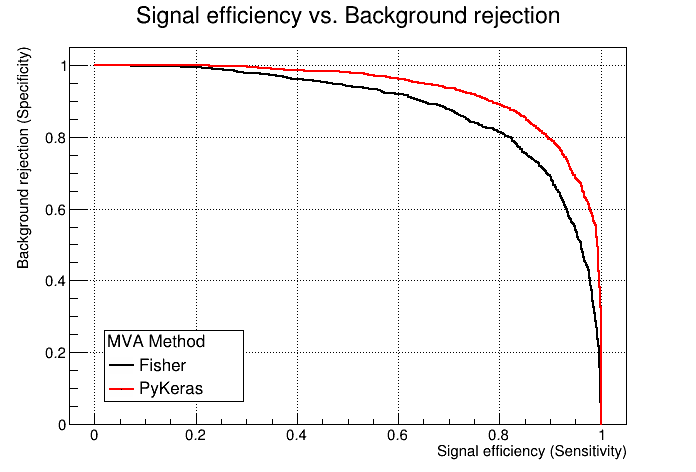

In [7]:
cROC = factory.GetROCCurve(dataloader)
cROC.Draw()
cROC.Print(".pdf") # This saves a PDF file of the canvas

TMVA-Classification-Keras.root:/dataset/Method_PyKeras/PyKeras


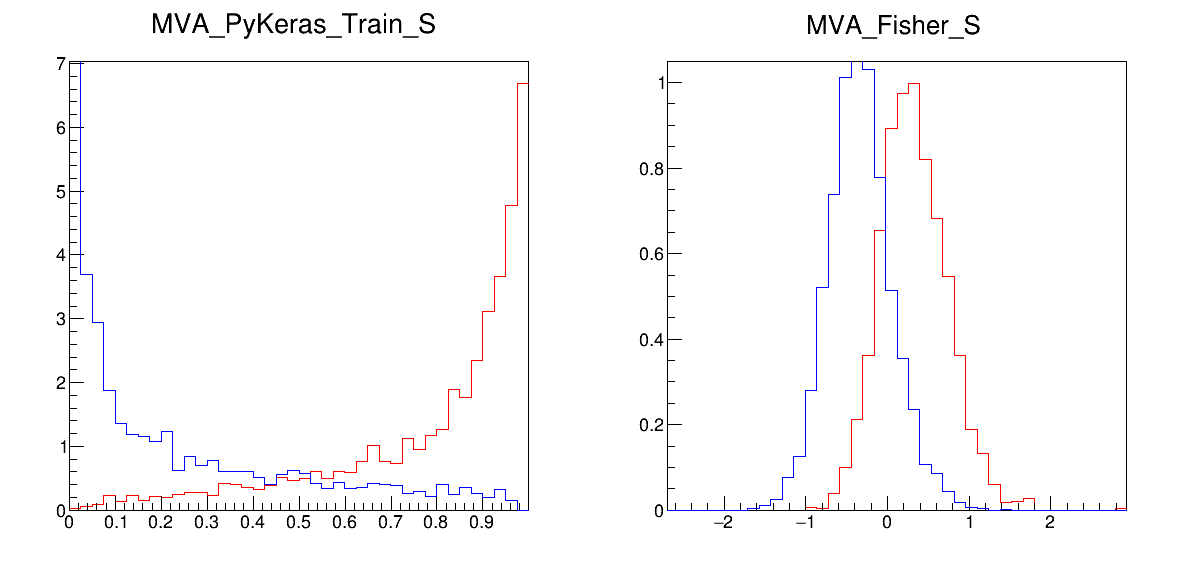

In [8]:
# Plotting some of the histograms inside the ROOT file produced by TMVA

cOut = ROOT.TCanvas("MVA Output", "", 1200, 600)
cOut.Divide(2,1)

cOut.cd(1)
output.cd()
ROOT.gDirectory.cd("dataset/Method_PyKeras/PyKeras")
hSig = ROOT.gDirectory.Get("MVA_PyKeras_Train_S")
hSig.SetLineColor(ROOT.kRed)
hSig.Draw("hist")
hBkg = ROOT.gDirectory.Get("MVA_PyKeras_B")
hBkg.SetLineColor(ROOT.kBlue)
hBkg.Draw("hist same")
ROOT.gDirectory.pwd()

cOut.cd(2)
output.cd()
output.cd("dataset/Method_Fisher/Fisher")
hSig = ROOT.gDirectory.Get("MVA_Fisher_S")
hSig.SetLineColor(ROOT.kRed)
hSig.Draw("hist")
hBkg = ROOT.gDirectory.Get("MVA_Fisher_Train_B")
hBkg.SetLineColor(ROOT.kBlue)
hBkg.Draw("hist same")

cOut.Draw()


In [9]:
# Closing the file where we have the methods trained
output.Close()
factory.Delete()

You can analyse the output using the 